# Model as we used i the original pyGIMLi(emg3d) development

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import emg3d

import sampledata

name = "pyGIMLi-Original"

In [2]:
%matplotlib widget

In [3]:
azimuth = 0.0
elevation = 0.0

# Receiver line
rec_x = np.arange(-7000, 7001, 250.)
rec_y = 0.0
rec_z = 0.0
rec = emg3d.surveys.txrx_coordinates_to_dict(
        emg3d.RxElectricPoint,
        (rec_x, rec_y, rec_z, azimuth, elevation)
)

# Sources
src_x = np.array([-6000, -4000, -2000, 0.0, 2000, 4000, 6000])
src_y = 0.0
src_z = 50.0
src = emg3d.surveys.txrx_coordinates_to_dict(
        emg3d.TxElectricDipole,
        (src_x, src_y, src_z, azimuth, elevation),
        strength=1000,
)

# Frequencies - roughly log-spaced from 0.1 Hz to 5 Hz
frequencies = np.round(np.logspace(-1, 0.7, 7), 1)

# Create a survey
survey = emg3d.surveys.Survey(
    sources=src,
    receivers=rec,
    frequencies=frequencies,
    noise_floor=1e-15,
    relative_error=0.03,
)

# QC
survey

:: Survey ::

<xarray.Dataset> Size: 47kB
Dimensions:   (src: 7, rec: 57, freq: 7)
Coordinates:
  * src       (src) <U6 168B 'TxED-1' 'TxED-2' 'TxED-3' ... 'TxED-6' 'TxED-7'
  * rec       (rec) <U7 2kB 'RxEP-01' 'RxEP-02' ... 'RxEP-56' 'RxEP-57'
  * freq      (freq) <U3 84B 'f-1' 'f-2' 'f-3' 'f-4' 'f-5' 'f-6' 'f-7'
Data variables:
    observed  (src, rec, freq) complex128 45kB (nan+nanj) ... (nan+nanj)
Attributes:
    noise_floor:     1e-15
    relative_error:  0.03

In [4]:
hx = np.ones(142)*100.0
hy = np.ones(62)*100.0
hz = np.ones(24)*100.0
grid = emg3d.TensorMesh([hx, hy, hz], [-7100, -3100, -2300])
grid

TensorMesh: 211,296 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    142     -7,100.00      7,100.00    100.00    100.00    1.00
   y     62     -3,100.00      3,100.00    100.00    100.00    1.00
   z     24     -2,300.00        100.00    100.00    100.00    1.00

In [5]:
model_init = emg3d.Model(grid, 1.0, mapping='Conductivity')
model_init.property_x[:, :, -1:] = 1/0.3

# Model with a target
model = model_init.copy()
model.property_x[41:-41, 1:-1, 1:6] = 1/100.0

model_init

Model: conductivity; isotropic; 142 x 62 x 24 (211,296)

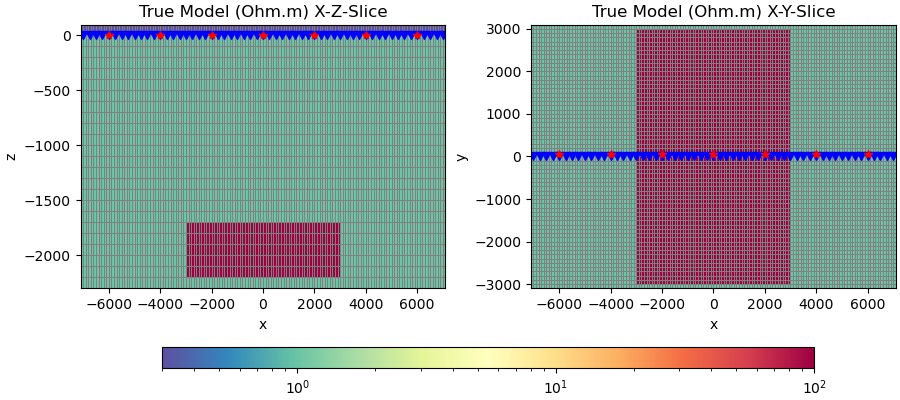

In [6]:
popts = {'edgecolors': 'grey', 'linewidth': 0.5, 'cmap':'Spectral_r','norm':LogNorm(vmin=0.3, vmax=100)}
rec_coords = survey.receiver_coordinates()
src_coords = survey.source_coordinates()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True, sharex=True)

opts = {'v_type': 'CC', 'normal': 'Y', 'pcolor_opts': popts}
out1, = grid.plot_slice(1/model.property_x.ravel('F'), ax=ax1, **opts)
ax1.set_title(f"True Model (Ohm.m) X-Z-Slice")
ax1.plot(rec_coords[0], rec_coords[1], 'bv')
ax1.plot(src_coords[0], src_coords[1], 'r*')
    
opts = {'v_type': 'CC', 'normal': 'Z', 'pcolor_opts': popts}
out2, = grid.plot_slice(1/model.property_x.ravel('F'), ax=ax2, ind=1, **opts)
ax2.set_title(f"True Model (Ohm.m) X-Y-Slice")
ax2.plot(rec_coords[0], rec_coords[2], 'bv')
ax2.plot(src_coords[0], src_coords[2], 'r*')

plt.colorbar(out1, ax=(ax1, ax2), orientation='horizontal', fraction=.1, shrink=.8, aspect=30)

In [7]:
simulation = emg3d.simulations.Simulation(
    survey=survey.copy(),
    model=model,
    gridding='both',
    max_workers=50,
    receiver_interpolation='linear',  # Currently necessary for the gradient
    gridding_opts={'vector': 'xyz'},
    solver_opts={'tol_gradient': 1e-3},
    tqdm_opts=False,
)
simulation

:: Simulation ::

- Survey: 7 sources; 57 receivers; 7 frequencies
- Model: conductivity; isotropic; 142 x 62 x 24 (211,296)
- Gridding: Frequency- and source-dependent grids; 160 x 80 x 32 (409,600) - 160 x 80 x 40 (512,000)

Data saved to «/home/dtr/Codes/devInv/data/pyGIMLi-Original.h5»
[emg3d v1.8.4.dev12+ge283125.d20240903 (format 1.0) on 2024-09-03T16:26:27.772941].
Data loaded from «/home/dtr/Codes/devInv/data/pyGIMLi-Original.h5»
[emg3d v1.8.4.dev12+ge283125.d20240903 (format 1.0) on 2024-09-03T16:26:27.772941].


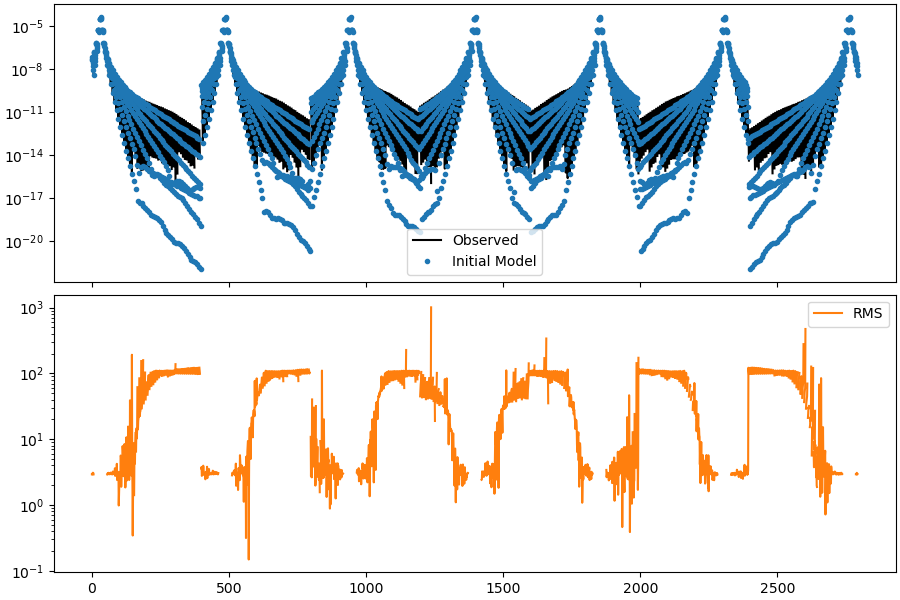

In [8]:
sampledata.create_data(name, simulation, model_init, min_offset=1000)
sampledata.plot_obs_initial(name)

In [9]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Tue Sep 03 16:26:28 2024 CEST

                OS : Linux (Ubuntu 22.04)
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC
  12.3.0]

             numpy : 1.26.4
             scipy : 1.14.0
             numba : 0.60.0
             emg3d : 1.8.4.dev12+ge283125.d20240903
           empymod : 2.3.2.dev7+g2133d34.d20240729
            xarray : 2024.6.0
        discretize : 0.10.1.dev15+gf89e5ff7.d20240902
              h5py : 3.11.0
        matplotlib : 3.9.0
              tqdm : 4.66.4
           IPython : 8.26.0
--------------------------------------------------------------------------------